## Basic analysis of headlines #1

In this task we are going to use the Paraphraser dataset to do basic text analysis operations on news headlines.
The dataset is a large .json file.



### Getting the dataset

In [3]:
from os import remove
from shutil import copyfileobj
import zipfile
import requests

def download_file(url):
    compressed_dataset = 'Headlines.zip'
    with requests.get(url, stream=True) as r:
        with open(compressed_dataset, 'wb') as f:
            copyfileobj(r.raw, f)
            
    archive = zipfile.ZipFile(compressed_dataset)
    for file in archive.namelist():
        if file.endswith('.json'):
            archive.extract(file)
            archive.close() # close file
            os.remove(compressed_dataset) 
    return file

In [ ]:
# download_file('http://paraphraser.ru/download/get?file_id=7')

### Getting familiar with data

In [5]:
import json
with open("ParaPhraserPlus/ParaPhraserPlus.json") as data_set:
    HEADLINE_SET = json.load(data_set)

In [6]:
HEADLINE_SET['0'].keys()

dict_keys(['rubric', 'date', 'headlines'])

In [7]:
list(HEADLINE_SET.items())[0]

('0',
 {'rubric': 'общество',
  'date': '2019/01/02',
  'headlines': ['Птичий праздник: Что такое "куриное рождество" и кто его отмечает',
   'Куриное Рождество в 2019 году: что это за праздник и как стать его главным героем']})

In [8]:
list(HEADLINE_SET.items())[0][1]['headlines']

['Птичий праздник: Что такое "куриное рождество" и кто его отмечает',
 'Куриное Рождество в 2019 году: что это за праздник и как стать его главным героем']

In [9]:
len(HEADLINE_SET)

1725393

### Starting the stage of analysis

In [10]:
import json
import nltk, razdel
from nltk.corpus import stopwords
from pymystem3 import Mystem
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Download nltk packages used in this example
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to /home/aliak/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/aliak/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [11]:
# Customize list of stopwords as needed. Here, we add common
# punctuation and contraction artifacts.
punctuations = list(string.punctuation)
stop_words = stopwords.words('russian') + punctuations

In [170]:
#Create lemmatizer and stopwords list
mystem = Mystem()
#Preprocess function
def preprocess_text(text):
    tokens = mystem.lemmatize(text.lower())
    tokens = [token for token in tokens if token not in stop_words\
              and token != " " \
              and token.strip() not in punctuations]
    
    text = " ".join(tokens)
    
    return [word for word in text.split(' ')]

In [139]:
def _score_sentences(sentences, important_words):
    N = 3  # Number of words to consider
    CLUSTER_DIST = 3  # Distance between words to consider
    scores = []
    sentence_idx = -1

    for s in [nltk.tokenize.word_tokenize(s) for s in sentences]:

        sentence_idx += 1
        word_idx = []

        # For each word in the word list...
        for w in important_words:
            try:
                # Compute an index for where any important words occur in the sentence.

                word_idx.append(s.index(w[0]))
            except ValueError: # w not in this particular sentence
                pass

        word_idx.sort()

        # It is possible that some sentences may not contain any important words at all.
        if len(word_idx)== 0: continue

        # Using the word index, compute clusters by using a max distance threshold
        # for any two consecutive words.

        clusters = []
        cluster = [word_idx[0]]
        i = 1
        while i < len(word_idx):
            if word_idx[i] - word_idx[i - 1] < CLUSTER_DIST:
                cluster.append(word_idx[i])
            else:
                clusters.append(cluster[:])
                cluster = [word_idx[i]]
            i += 1
        clusters.append(cluster)

        # Score each cluster. The max score for any given cluster is the score 
        # for the sentence.

        max_cluster_score = 0
        for c in clusters:
            significant_words_in_cluster = len(c)
            total_words_in_cluster = c[-1] - c[0] + 1
            score = 1.0 * significant_words_in_cluster \
                * significant_words_in_cluster / total_words_in_cluster

            if score > max_cluster_score:
                max_cluster_score = score

        scores.append((sentence_idx, score))

    return scores

In [171]:
%matplotlib inline
import warnings
from IPython.display import display
warnings.filterwarnings("ignore")

def headline_stats_by_article(article_num):
    sentences = []
    tokens = []
    
    rubric = list(HEADLINE_SET.items())[article_num][1]['rubric']
    headlines = list(HEADLINE_SET.items())[article_num][1]['headlines']
    
    sentences += [_.text for each_headline in headlines for _ in razdel.sentenize(each_headline)]
    tokens += [token.text.lower() for sentence in sentences 
               for token in razdel.tokenize(sentence)]
        
    corpus = [word for word in tokens if word[0] not in stop_words]
    # Basic stats
    fdist = nltk.FreqDist(corpus)

    num_words = sum([i for i in fdist.values()])
    num_unique_words = len(fdist.items())

    average_word_length = round(sum(len(word) for word in corpus) / len(corpus), 2)
    max_word_length = np.max(np.array([len(word) for word in corpus]))
    average_sentence_length = round(len(corpus) / len(sentences), 2)

    # Hapaxes are words that appear only once
    num_hapaxes = len(fdist.hapaxes())

    top_10_words = fdist.most_common(10)
    normalized_sentences = [s.lower() for s in sentences]
    TOP_SENTENCES = 5  # Number of sentences to return for a "top n" summary
    scored_sentences = _score_sentences(normalized_sentences, top_10_words)

    # Summarization Approach 1:
    # Filter out nonsignificant sentences by using the average score plus a
    # fraction of the std dev as a filter

    avg = np.mean([s[1] for s in scored_sentences])
    std = np.std([s[1] for s in scored_sentences])
    mean_scored = [(sent_idx, score) for (sent_idx, score) in scored_sentences
                   if score > avg + 0.5 * std]

    # Summarization Approach 2:
    # Another approach would be to return only the top N ranked sentences

    top_n_scored = sorted(scored_sentences, key=lambda s: s[1])[-TOP_SENTENCES:]
    top_n_scored = sorted(top_n_scored, key=lambda s: s[0])

        
    print("---------------------Article {%d}-----------------------" % article_num)
    print(rubric)
    print('\tMaximum word length in headline:'.ljust(25), max_word_length)
    print('\tAverage length of a word (letterwise):'.ljust(25), average_word_length)
    print('\tAverage length headline length(wordwise):'.ljust(25), average_sentence_length)
    print('\tNum Sentences:'.ljust(25), len(sentences))
    print('\tNum Words:'.ljust(25), num_words)
    print('\tNum Unique Words:'.ljust(25), num_unique_words)
    print('\tNum Hapaxes:'.ljust(25), num_hapaxes)
    print('\tTop 10 Most Frequent Words (stop words):\n\t\t', \
            '\n\t\t'.join(['%s (%s)'
            % (w[0], w[1]) for w in top_10_words]))
    print("-------------------------------------------------------")
    print("-------HEADLINES(Picked/blue -- original/black)--------")
    top_n_summary=[sentences[idx] for (idx, score) in top_n_scored]
    mean_scored_summary=[sentences[idx] for (idx, score) in mean_scored]
    for sen in sentences:
        if (sen) in set(mean_scored_summary and top_n_summary):
            print("\x1b[94m"+sen+"\x1b[0m"+"\t")
        else:
            print(sen)
    print("-------------------------------------------------------")
    for (idx, score) in mean_scored:
        print(sentences[idx], score)
    print("------------------------------------------------------")
    print("-------------------Lemmatized text--------------------")
    print("------------------------------------------------------")
    for sentence in sentences:
        print("Original==>\t"+sentence)
        print("Preprocessed==>\t"+"\x1b[35m" +' '.join(preprocess_text((sentence))) +"\x1b[0m")
    print("-----------------------------------------------------")
    data = []

    for word,freq in fdist.most_common(10):
        data.append({'Word':word,'Frequency':freq})

    df = pd.DataFrame(data)

    # Create a bar graph with the most commonly used descriptors
    df['Word']=df['Word'].str.capitalize()
    
    fig, axes = plt.subplots(nrows=1, ncols=2)
    df.plot(kind='barh', x='Word',y='Frequency', ax=axes[0], figsize=(15,5),color='#cb101c')
    df.plot(kind='line', x='Word',y='Frequency', ax=axes[1], figsize=(15,5))

    
    pos_tagged_tokens = [nltk.pos_tag(t) for t in tokens]

    # Flatten the list since we're not using sentence structure
    # and sentences are guaranteed to be separated by a special
    # POS tuple such as ('.', '.')

    pos_tagged_tokens = [token for sent in pos_tagged_tokens for token in sent]

    all_entity_chunks = []
    previous_pos = None
    current_entity_chunk = []
    for (token, pos) in pos_tagged_tokens:

        if pos == previous_pos and pos.startswith('NN'):
            current_entity_chunk.append(token)
        elif pos.startswith('NN'):
            if current_entity_chunk != []:

                # Note that current_entity_chunk could be a duplicate when appended,
                # so frequency analysis again becomes a consideration

                all_entity_chunks.append((' '.join(current_entity_chunk), pos))
            current_entity_chunk = [token]

        previous_pos = pos

    # Store the chunks as an index for the document
    # and account for frequency while we're at it...

#     article_headlines = {}
#     for c in all_entity_chunks:
#         article_headlines['entities'][c] = article_headlines['entities'].get(c, 0) + 1

#     # For example, we could display just the title-cased entities

#     proper_nouns = []
#     for (entity, pos) in article_headlines['entities']:
#         if entity.istitle():
#             print('\t%s (%s)' % (entity, article_headlines['entities'][(entity, pos)]))


---------------------Article {25}-----------------------
общество
	Maximum word length in headline: 16
	Average length of a word (letterwise): 7.16
	Average length headline length(wordwise): 5.55
	Num Sentences:           11
	Num Words:               61
	Num Unique Words:        21
	Num Hapaxes:             15
	Top 10 Most Frequent Words (stop words):
		 whatsapp (11)
		на (11)
		некоторых (9)
		работать (7)
		перестанет (5)
		телефонах (3)
		мессенджер (1)
		нового (1)
		года (1)
		недоступен (1)
-------------------------------------------------------
-------HEADLINES(Picked/blue -- original/black)--------
Мессенджер WhatsApp перестанет работать на некоторых телефонах	
WhatsApp с нового года недоступен на некоторых телефонах	
WhatsApp перестанет работать на некоторых смартфонах с января	
WhatsApp прекращает работу на некоторых операционных системах
WhatsApp перестал работать на некоторых смартфонах
Эксперт прокомментировал прекращение работы WhatsApp на ряде устройств
WhatsApp не буде

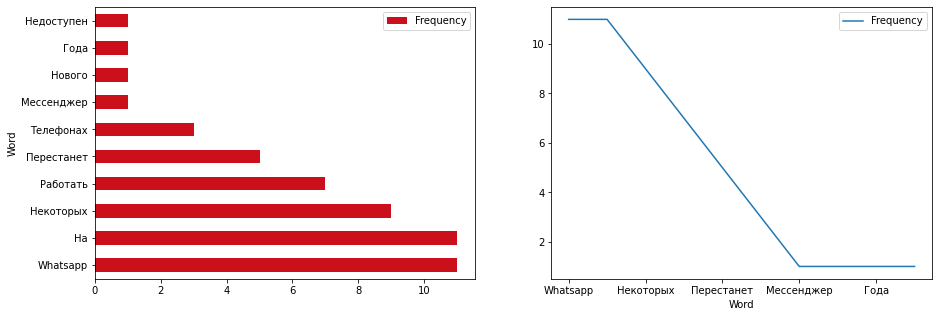

In [172]:
headline_stats_by_article(25) # article id being passed as parameter, data aggregation is also a possible option for later.

#### Comment: 
From the resul.ts that we have obtained, we can see that the way we scored the sentences is good, but can be improved a bit.. for instance, the sentence with the highest score, has the word "Messanger", which is redundant, also it does not give any information like when this will happen and is it for all phones or only for old, etc. This happens because the score mechanism that we have used has no information about the entities that each word represnts, having information about the type/entities that a word represnts, can help to have a better scoring mechanism if we give entites like "Date" more importance, while giving words like "Messanger" less.

In [ ]:
from ipymarkup import show_span_box_markup, show_dep_markup

### Bag Of Words for the headlines of each article

### n-grams model 

### LDA using TF-IDF

#### Intertopic Distance Plot can help you learn about how topics relate to each other, including potential higher-level structure between groups of topics.